# EVALUATION FINALE & PREDICTIONS - CHURN PREDICTION

### **Objectif**: Evaluer le modele final sur le test set et generer les predictions

### **Contenu**:
#### 1. Chargement du meilleur modele
#### 2. Evaluation sur le test set
#### 3. Analyse des erreurs
#### 4. Predictions finales
#### 5. Interpretation et recommandations business

## IMPORTATION DES BIBLIOTHEQUES

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

import joblib
from pathlib import Path
import json

In [56]:
np.random.seed(42)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Bibliotheques importees avec succes!")

Bibliotheques importees avec succes!


## CHARGEMENT DES DONNEES ET DU MODELE

In [57]:
# Detecter le chemin de base
current_path = Path.cwd()
if current_path.name == 'notebooks':
    base_path = current_path.parent
else:
    base_path = current_path

processed_path = base_path / 'data' / 'processed'
models_path = base_path / 'models' / 'saved_models'

print("="*60)
print("CHARGEMENT DES DONNEES ET DU MODELE")
print("="*60)

CHARGEMENT DES DONNEES ET DU MODELE


In [58]:
# Charger les donnees de validation et test
X_val = pd.read_csv(processed_path / 'X_val.csv')
y_val = pd.read_csv(processed_path / 'y_val.csv')['Exited']
X_test = pd.read_csv(processed_path / 'X_test.csv')

print(f"\nValidation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Validation set: (33007, 24)
Test set: (110023, 24)


In [59]:
# Lister les modeles disponibles
available_models = list(models_path.glob('best_model_*.pkl'))

print(f"\nModeles disponibles ({len(available_models)}):")
for i, model_file in enumerate(available_models, 1):
    print(f"  {i}. {model_file.name}")

# Charger le meilleur modele
if available_models:
    best_model_path = available_models[0]
    best_model = joblib.load(best_model_path)
    model_name = best_model_path.stem.replace('best_model_', '').replace('_', ' ').title()
    print(f"\nModele charge: {model_name}")
    print(f"Chemin: {best_model_path}")
else:
    print("\nAucun modele trouve. Veuillez d'abord executer le notebook 03.")
    raise FileNotFoundError("Aucun modele sauvegarde trouve")

# %%
# Charger les resultats precedents si disponibles
results_files = list(models_path.glob('model_results_*.pkl'))
if results_files:
    results_data = joblib.load(results_files[0])
    print("\nResultats precedents charges:")
    print(f"  - Validation Accuracy: {results_data['validation_metrics']['val_accuracy']:.4f}" )
    print(f"  - Validation Precision: {results_data['validation_metrics']['val_precision']:.4f}")
    print(f"  - Validation Recall: {results_data['validation_metrics']['val_recall']:.4f}")
    print(f"  - Validation ROC-AUC: {results_data['validation_metrics']['val_roc_auc']:.4f}")
    print(f"  - Validation F1-Score: {results_data['validation_metrics']['val_f1']:.4f}")


Modeles disponibles (1):
  1. best_model_lightgbm.pkl

Modele charge: Lightgbm
Chemin: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/models/saved_models/best_model_lightgbm.pkl

Resultats precedents charges:
  - Validation Accuracy: 0.8155
  - Validation Precision: 0.5439
  - Validation Recall: 0.7927
  - Validation ROC-AUC: 0.8889
  - Validation F1-Score: 0.6451


## PREDICTIONS SUR LE TEST SET

In [60]:
print("="*60)
print("PREDICTIONS SUR LE TEST SET")
print("="*60)

PREDICTIONS SUR LE TEST SET


In [61]:
# Verifier si le test set a des labels
has_test_labels = 'Exited' in X_test.columns or (base_path / 'data' / 'raw' / 'test.csv').exists()

if has_test_labels:
    # Charger les vrais labels si disponibles
    test_raw = pd.read_csv(base_path / 'data' / 'raw' / 'test.csv')
    if 'Exited' in test_raw.columns:
        y_test = test_raw['Exited']
        print("\nLabels test trouves - Evaluation complete possible")
    else:
        y_test = None
        print("\nPas de labels test - Predictions uniquement")
else:
    y_test = None
    print("\nPas de labels test - Predictions uniquement")


Pas de labels test - Predictions uniquement


In [62]:
# Generer les predictions
print("\nGeneration des predictions...")
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_proba_exact = best_model.predict_proba(X_test)
predicted_prob = y_test_proba_exact[np.arange(len(y_test_proba_exact)), y_test_pred]

print(f"Predictions generees: {len(y_test_pred)}")
print(f"\nDistribution des predictions:")
pred_counts = pd.Series(y_test_pred).value_counts()
print(f"  Reste (0): {pred_counts[0]} ({pred_counts[0]/len(y_test_pred)*100:.2f}%)")
print(f"  Parti (1): {pred_counts[1]} ({pred_counts[1]/len(y_test_pred)*100:.2f}%)")


Generation des predictions...
Predictions generees: 110023

Distribution des predictions:
  Reste (0): 76353 (69.40%)
  Parti (1): 33670 (30.60%)


## ANALYSE DES ERREURS

## GENERATION DU FICHIER DE SOUMISSION

GENERATION DU FICHIER DE SOUMISSION

--- STATISTIQUES DES ExitedS ---

Exiteds Churn (1): 33670 (30.60%)
Exiteds Non-Churn (0): 76353 (69.40%)

Probabilites:
  Minimum: 0.0114
  Maximum: 0.9932
  Moyenne: 0.3635
  Mediane: 0.2612


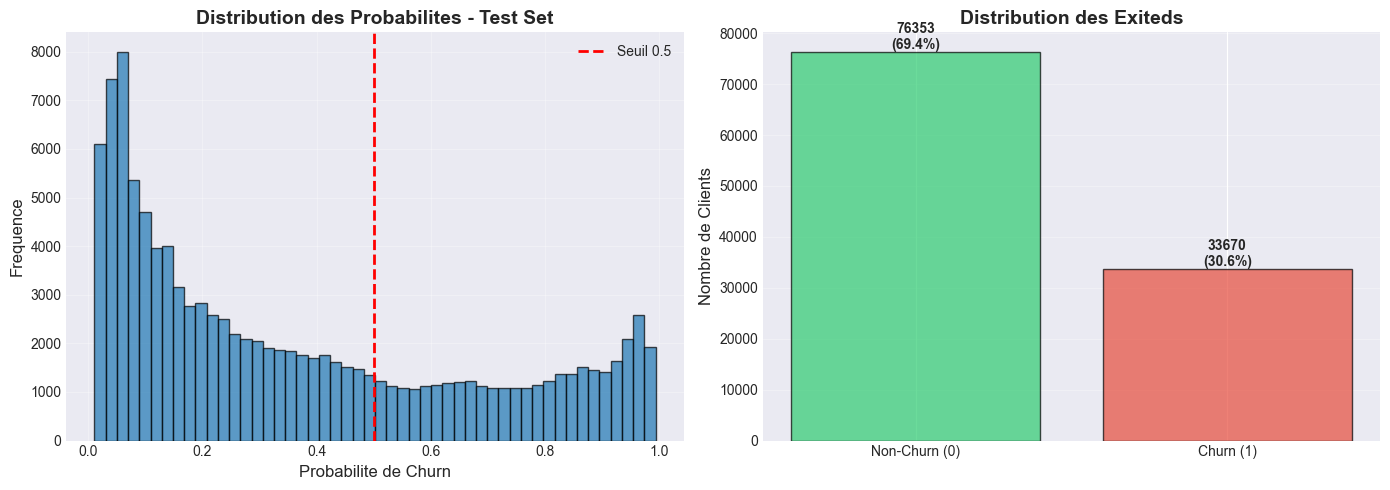

In [63]:
print("="*60)
print("GENERATION DU FICHIER DE SOUMISSION")
print("="*60)

# Creer un DataFrame avec les Predictions
submission_df = pd.DataFrame({
    'Exited': y_test_pred,
    'probability': y_test_proba,
    'predicted_prob': predicted_prob
})

# Ajouter l'ID si disponible
test_raw = pd.read_csv(base_path / 'data' / 'raw' / 'test.csv')
if 'id' in test_raw.columns:
    submission_df.insert(0, 'id', test_raw['id'])
elif 'CustomerId' in test_raw.columns:
    submission_df.insert(0, 'id', test_raw['CustomerId'])



# %%
# Statistiques des Exiteds
print("\n--- STATISTIQUES DES ExitedS ---")
print(f"\nExiteds Churn (1): {(submission_df['Exited'] == 1).sum()} ({(submission_df['Exited'] == 1).sum()/len(submission_df)*100:.2f}%)")
print(f"Exiteds Non-Churn (0): {(submission_df['Exited'] == 0).sum()} ({(submission_df['Exited'] == 0).sum()/len(submission_df)*100:.2f}%)")

print(f"\nProbabilites:")
print(f"  Minimum: {submission_df['probability'].min():.4f}")
print(f"  Maximum: {submission_df['probability'].max():.4f}")
print(f"  Moyenne: {submission_df['probability'].mean():.4f}")
print(f"  Mediane: {submission_df['probability'].median():.4f}")

# %%
# Distribution des probabilites
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(submission_df['probability'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Probabilite de Churn', fontsize=12)
ax1.set_ylabel('Frequence', fontsize=12)
ax1.set_title('Distribution des Probabilites - Test Set', fontsize=14, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil 0.5')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = axes[1]
pred_counts = submission_df['Exited'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax2.bar(['Non-Churn (0)', 'Churn (1)'], pred_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Nombre de Clients', fontsize=12)
ax2.set_title('Distribution des Exiteds', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, pred_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/len(submission_df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

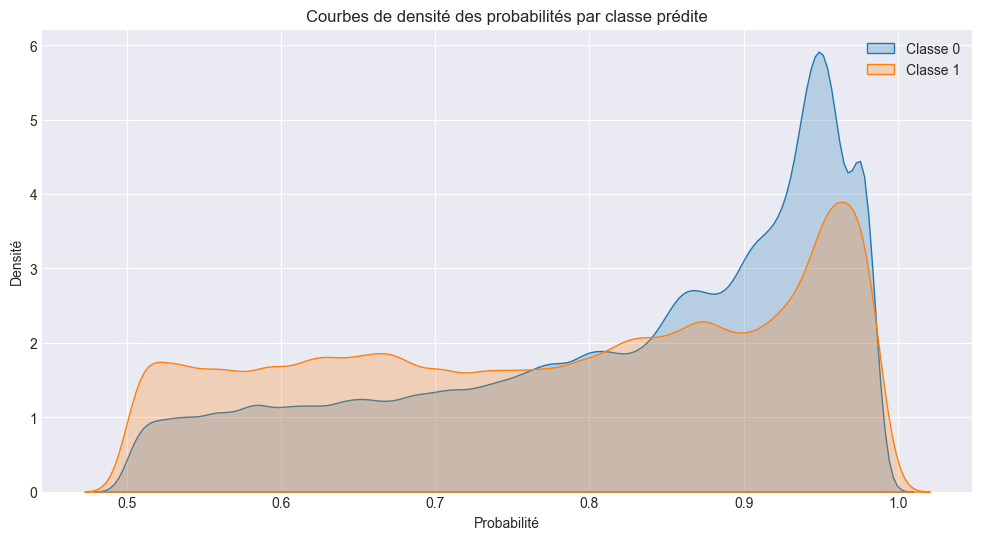

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Classe 0
sns.kdeplot(
    data=submission_df[submission_df["Exited"] == 0],
    label="Classe 0",
    x="predicted_prob",
    fill=True,
    bw_adjust=0.5
)

# Classe 1
sns.kdeplot(
    data=submission_df[submission_df["Exited"] == 1],
    x="predicted_prob",
    label="Classe 1",
    fill=True,
    bw_adjust=0.5
)

plt.title("Courbes de densité des probabilités par classe prédite")
plt.xlabel("Probabilité")
plt.ylabel("Densité")
plt.legend()
plt.show()


In [65]:
# Sauvegarder le fichier de soumission
submission_df = submission_df.drop(columns=['predicted_prob', 'probability'], errors='ignore')
submission_path = base_path / 'data' / 'processed' / 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nFichier de soumission cree: {submission_path}")
print(f"Nombre de lignes: {len(submission_df)}")
print(f"\nApercu:")
display(submission_df.head(10))


Fichier de soumission cree: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/data/processed/submission.csv
Nombre de lignes: 110023

Apercu:


,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,1
4,165038,1
5,165039,0
6,165040,0
7,165041,0
8,165042,1
9,165043,0


## RECOMMANDATIONS BUSINESS

In [66]:
print("""
RECOMMANDATIONS OPERATIONNELLES:

1. SEGMENTATION DES CLIENTS:
   - Probabilite > 0.7: Action immediate (appel personnalise)
   - Probabilite 0.5-0.7: Email cible avec offre
   - Probabilite 0.3-0.5: Newsletter avec avantages
   - Probabilite < 0.3: Communication standard

2. ACTIONS DE RETENTION:
   - Offrir une reduction temporaire
   - Proposer des produits complementaires
   - Ameliorer le service client
   - Programme de fidelite renforce

3. MONITORING:
   - Recalculer les scores mensuellement
   - Suivre le taux de conversion des actions
   - Ajuster le seuil selon les resultats business
   - Reent rainer le modele trimestriellement

4. PROCHAINES AMELIORATIONS:
   - Integrer des donnees comportementales temps reel
   - Tester des modeles plus complexes (Deep Learning)
   - Ajouter des features d'interaction client
   - Implementer un systeme de scoring en temps reel
""")

print("="*80)
print("EVALUATION FINALE TERMINEE AVEC SUCCES!")
print("="*80)


RECOMMANDATIONS OPERATIONNELLES:

1. SEGMENTATION DES CLIENTS:
   - Probabilite > 0.7: Action immediate (appel personnalise)
   - Probabilite 0.5-0.7: Email cible avec offre
   - Probabilite 0.3-0.5: Newsletter avec avantages
   - Probabilite < 0.3: Communication standard

2. ACTIONS DE RETENTION:
   - Offrir une reduction temporaire
   - Proposer des produits complementaires
   - Ameliorer le service client
   - Programme de fidelite renforce

3. MONITORING:
   - Recalculer les scores mensuellement
   - Suivre le taux de conversion des actions
   - Ajuster le seuil selon les resultats business
   - Reent rainer le modele trimestriellement

4. PROCHAINES AMELIORATIONS:
   - Integrer des donnees comportementales temps reel
   - Tester des modeles plus complexes (Deep Learning)
   - Ajouter des features d'interaction client
   - Implementer un systeme de scoring en temps reel

EVALUATION FINALE TERMINEE AVEC SUCCES!
